# LaQuacco 🍅🍅🍅

### Laboratory Quality Control v2.1 (2025-10-09)

#### https://github.com/himsr-lab/LaQuacco

### User Input

In [1]:
# 1) adjust runtime behavior

"""
Basic: Adjust these variable values as needed.
"""
# Absolute or relative path to directory with image data
#
# Examples:
# r"./tests"  (default)
# r"C:\User\Desktop\images"
# r"\\data.server.edu\labs\pi\project\data"
#
images_path = r"./tests"

# Accepted file extensions for matching
#
# Examples:
# "*.ome.tiff"  (default)
# "*.qptiff"
# "*.tif"
#
images_included = "*.ome.tiff"

# Rejected file extensions for matching
#
# Examples:
# "" (default)
# "*.tiff"
#
images_excluded = ""

"""
Advanced: Adjust these variables to customize runtime behavior.
"""
# Define closed channel intervals with endpoints (case-sensitive)
#
# Examples:
# 
# {"*": {"lower": None, "upper": None}}  (default, all channels)
# {"*": {"lower": 1e-7, "upper": None}}  (all channels, ignore zeros)
# {"*": {"lower": 1e-7}, "Channel 1": {"upper": 5.0}  (combined limits)
# 
channel_limits = {"*": {"lower": None, "upper": None}}
# Customize these variables to your needs
copy_images = False  # create a local copy before processing
figure_dimensions = (1460, 822)  # width and height in pixels
list_outliers = True  # list outliers in addition to plotting
max_plots_warn = 100  # warning will be displayed above plot limit
recursive_search = False  # search recursively for images at path

"""
QPTIFF: Limit analysis to rectangular annotations of type "FlaggedForAnalysis".
"""
use_annotations = False  # ignore pixels outside annotations

"""
Dataset:  Running this cell lists all image files found.
"""
import os
import laquacco as laq
import qptiff as qpt

files = laq.get_files(
    path=os.path.abspath(images_path),
    pat=images_included,
    anti=images_excluded,
    recurse=recursive_search,
)
print(f"Images: {len(files)}")
dirs_files = {
    dir: [os.path.basename(file) for file in files if os.path.dirname(file) == dir]
    for dir in set(os.path.dirname(file) for file in files)
}
dirs_files = dict(sorted(dirs_files.items()))
for dir, dir_files in dirs_files.items():
    print(f"=> {dir}")
    print(f"{sorted(dir_files)}")

print("\nCompleted.")

Images: 5
=> /Users/christian/Documents/GitHub/LaQuacco/tests
['image_1.ome.tiff', 'image_2.ome.tiff', 'image_3.ome.tiff', 'image_4.ome.tiff', 'image_5.ome.tiff']

Completed.


### Sampling I

In [2]:
# 2) retrieve image data (individual statistics)
import os
import shutil
import time

imgs = {}  # image dictionary
annos = {}  # annotation dictionary
imgs_chans_stats = {}  # statistics dictionary

start = time.time()
update_start = ""
update_stop = ""
update_max = 0
files_len = len(files)
for count, file in enumerate(files, start=1):
    update_start = f"IMAGE: {file}\t[{count}/{files_len}]"
    update_len = len(update_start) + len(update_stop)
    update_max = update_len if update_len > update_max else update_max
    print(f"\r{update_start}{update_stop}{' ':<{update_max - update_len}}", end="")

    # get individual statistics
    tmp = laq.copy_file(file) if copy_images else file  # optional file copy
    img = laq.get_img(tmp)
    imgs[file] = {k: v for k, v in img.items()}
    # prepare annotations
    annos[file] = None
    if use_annotations:
        anno = qpt.get_xml(file)  # optional annotations file
        if os.path.exists(anno):
            offsets = qpt.get_offsets(img["tags"][0])
            annos[file] = qpt.get_rectangles(anno, offsets)
    imgs_chans_stats[file] = laq.get_img_chans_stats(
        imgs[file], annos=annos[file], chans_limits=channel_limits
    )

    # remove image objects
    img["tiff"].close()
    if copy_images and tmp != file:
        shutil.rmtree(os.path.dirname(tmp))

    update_stop = f" (-{laq.get_time_left(start, count, len(files))})"
print(f"\r{' ' * update_max}\r", end="")  # clear line

print("\n-> Completed.")

                                                                                     
-> Completed.


### Summary I

In [3]:
# 3) print image data (individual statistics)
import warnings
import numpy as np

# sort data by acquisition
sorted_acqs = sorted(imgs.keys(), key=lambda k: imgs[k]["datetimes"][0])
imgs = {k: imgs[k] for k in sorted_acqs}
imgs_paths = list(imgs.keys())
imgs_chans_stats = {k: imgs_chans_stats[k] for k in sorted_acqs}

# get data summary
chans = sorted(
    list(
        set(
            chan
            for chans_stats in imgs_chans_stats.values()
            for chan in chans_stats.keys()
        )
    )
)
stats = sorted(
    list(
        set(
            stat
            for chans_stats in imgs_chans_stats.values()
            for stat in chans_stats.values()
            for stat in stat.keys()
        )
    )
)
chans_stats = {
    chan: {
        stat: np.asarray(
            [
                imgs_chans_stats[img][chan][stat]
                if chan in imgs_chans_stats[img]
                else None
                for img in imgs_chans_stats.keys()
            ],
            dtype=np.float64,
        )
        for stat in stats
    }
    for chan in chans
}
chans_means = {
    chan: {
        stat: np.nanmean(
            chans_stats[chan][stat]
            if chan in chans_stats and stat in chans_stats[chan]
            else np.nan
        )
        for stat in stats
    }
    for chan in chans
}

# check data (appears after prints)
def min_warning(message, category, filename, lineno, line=None):
    return f"{category.__name__}: {message}\n"
warnings.formatwarning = min_warning  # category and message
warnings.simplefilter("always", UserWarning)  # do repeat
expos_found = {
    chan: [
        expo
        for meta in imgs.values()
        for ch, expo in zip(meta["channels"], meta["exposures"])
        if ch == chan
    ]
    for chan in set(ch for meta in imgs.values() for ch in meta["channels"])
}
stats_missing = {
    chan: [
        stat
        for stat in chans_stats[chan]
        for index, value in enumerate(chans_stats[chan][stat])
        if np.isnan(value)
    ]
    for chan in chans_stats
}
for chan in chans:
    expos_set = sorted(set(expos_found[chan]))
    if len(expos_set) > 1:  # exposure times differ
        warnings.warn(
            f"{chan}: Exposure times are not identical!\n{expos_set}", UserWarning
        )
    stats_set = sorted(set(stats_missing[chan]))
    if len(stats_missing[chan]) > 0:  # statistics incomplete
        warnings.warn(
            f"{chan}: Statistics are missing for some images!\n{stats_set}",
            UserWarning,
        )

# print data (appears before warnings)
imgs_str_len = len(str(len(imgs)))
for pos, img in enumerate(imgs):
    print(f'{pos:>{imgs_str_len}} => "{img}"  # {imgs[img]['datetimes'][0]}')
print()
for chan in chans:
    print(
        f"{chan} @ {', '.join([f'{value}{unit}' for value, unit in sorted(set(expos_found[chan]))])}"
    )
    for stat in stats:
        print(
            f"\t{stat}\t{np.nanmean(chans_stats[chan][stat]):7.1f} (mean)\t{np.nanstd(chans_stats[chan][stat]):7.1f} (std)"
        )

print("\n-> Completed.")

0 => "/Users/christian/Documents/GitHub/LaQuacco/tests/image_1.ome.tiff"  # 2024-09-22 17:45:28
1 => "/Users/christian/Documents/GitHub/LaQuacco/tests/image_2.ome.tiff"  # 2024-09-22 17:46:58
2 => "/Users/christian/Documents/GitHub/LaQuacco/tests/image_3.ome.tiff"  # 2024-09-22 17:48:28
3 => "/Users/christian/Documents/GitHub/LaQuacco/tests/image_4.ome.tiff"  # 2024-09-22 17:49:58
4 => "/Users/christian/Documents/GitHub/LaQuacco/tests/image_5.ome.tiff"  # 2024-09-22 17:51:28

Channel 1 @ 0.001s
	max	  255.0 (mean)	    0.0 (std)
	mean	  128.9 (mean)	   18.3 (std)
	min	    0.0 (mean)	    0.0 (std)
Channel 2 @ 0.001s
	max	  255.0 (mean)	    0.0 (std)
	mean	  127.4 (mean)	    0.0 (std)
	min	    0.0 (mean)	    0.0 (std)

-> Completed.


### Distribution - Violin Chart

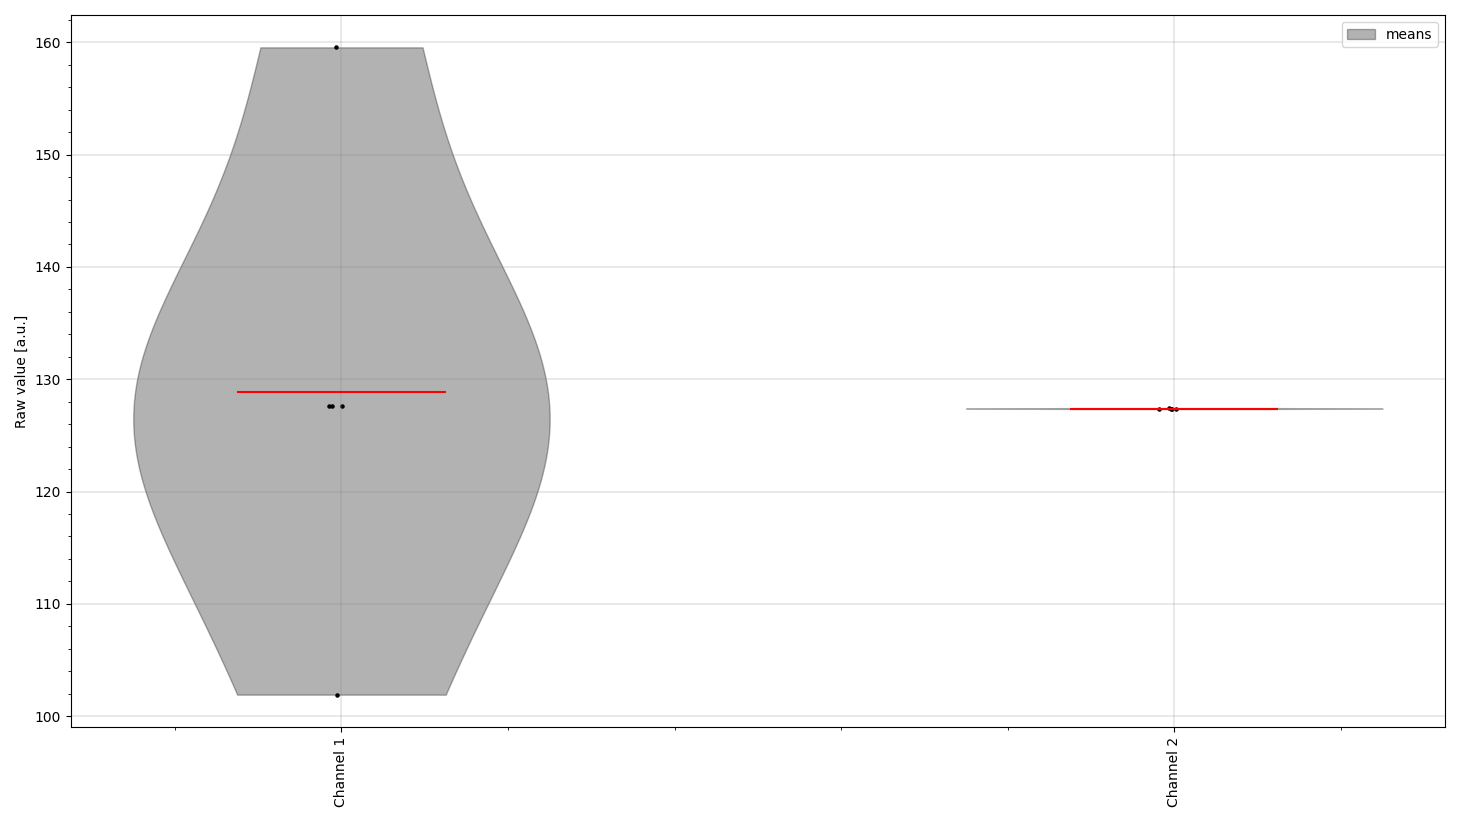

-> Completed.


In [4]:
# 4) plot image data (individual distributions)

import matplotlib as mpl
%matplotlib ipympl

# suppress cryptic warning about missing (`np.nan`) data
warnings.filterwarnings("ignore", message="invalid value encountered in det")

# change limit of opened plots before warning is displayed
mpl.rcParams['figure.max_open_warning'] = max_plots_warn

# prepare figure dimensions
dpi = mpl.pyplot.rcParams["figure.dpi"]
min_pixw, min_pixh = figure_dimensions
min_width, min_height = min_pixw / dpi, min_pixh / dpi
mpl.pyplot.rcParams["figure.figsize"] = [min_width, min_height]

# prepare variables for plotting
xy_vals = list(zip(*[(chan, stats["mean"]) for chan, stats in chans_stats.items()]))

# create violin plot
fig, ax = mpl.pyplot.subplots()
ax.set_xticks(range(1, len(xy_vals[0]) + 1), labels=chans, rotation=90)
vp = ax.violinplot(xy_vals[1], showmeans=True, showextrema=False)

# adjust colors
for p in vp["bodies"]:
    p.set_facecolor("black")
    p.set_edgecolor("black")
for m in ["cmeans"]:
    vp[m].set_edgecolor("red")

# add legend
legend = mpl.pyplot.legend(
    [vp["bodies"][0]],
    ["means"],
)

# add jittered dots
jit_means = np.concatenate(xy_vals[1])
jit = np.random.normal(0, 0.01, size=jit_means.size)
positions = np.repeat(np.arange(1, len(xy_vals[0]) + 1), len(xy_vals[1][0])) + jit
ax.scatter(positions, jit_means, color="black", s=5)

# adjust axes
mpl.pyplot.minorticks_on()

# add Y-axis label
mpl.pyplot.ylabel("Raw value [a.u.]")

# add grid
mpl.pyplot.grid(color="gray", linewidth=0.25)

# show plot
mpl.pyplot.tight_layout()
mpl.pyplot.show()

print("-> Completed.")

### Stability: Levey-Jennings Charts


Channel 1:


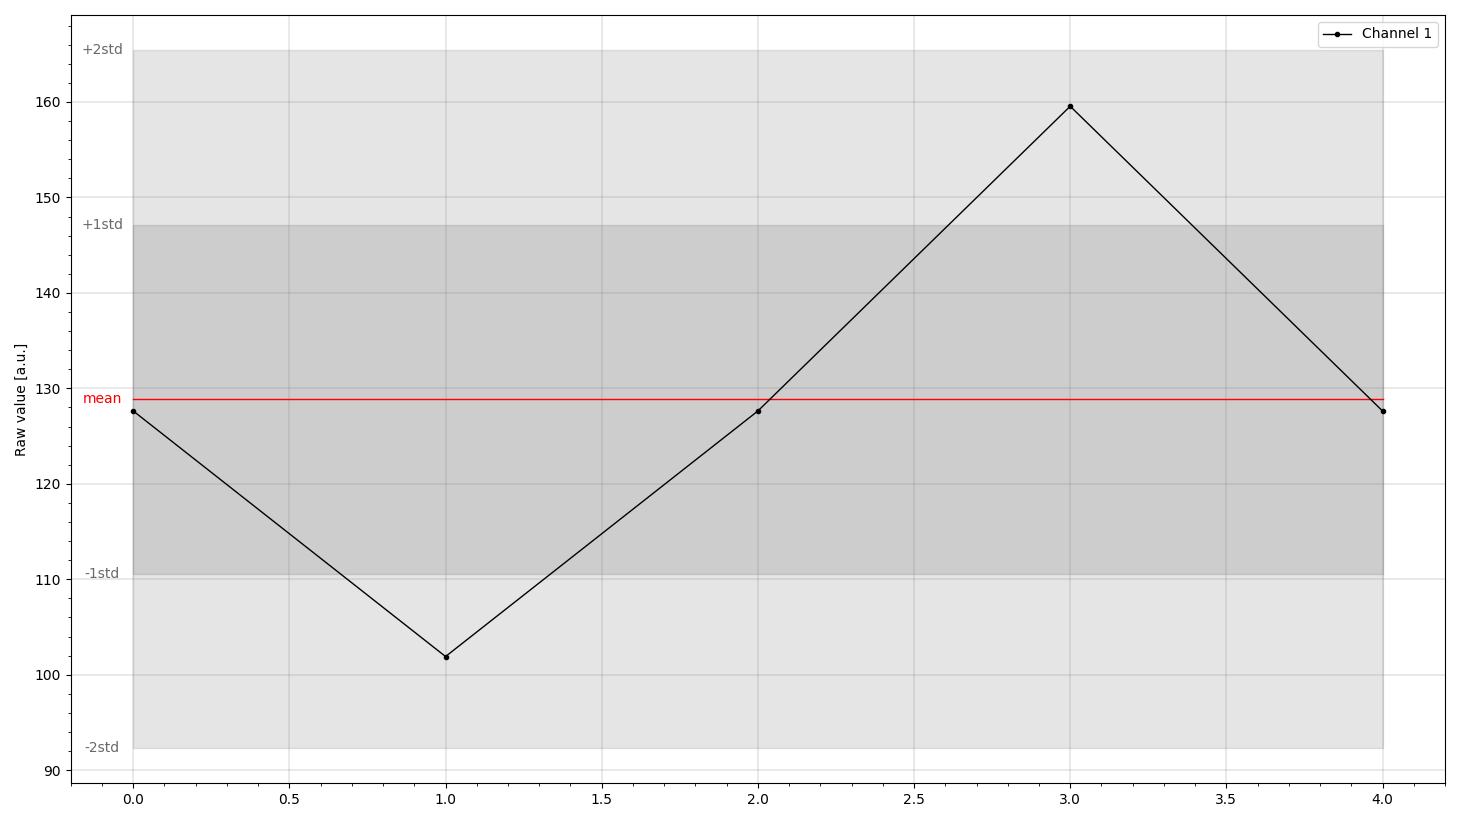


Channel 2:


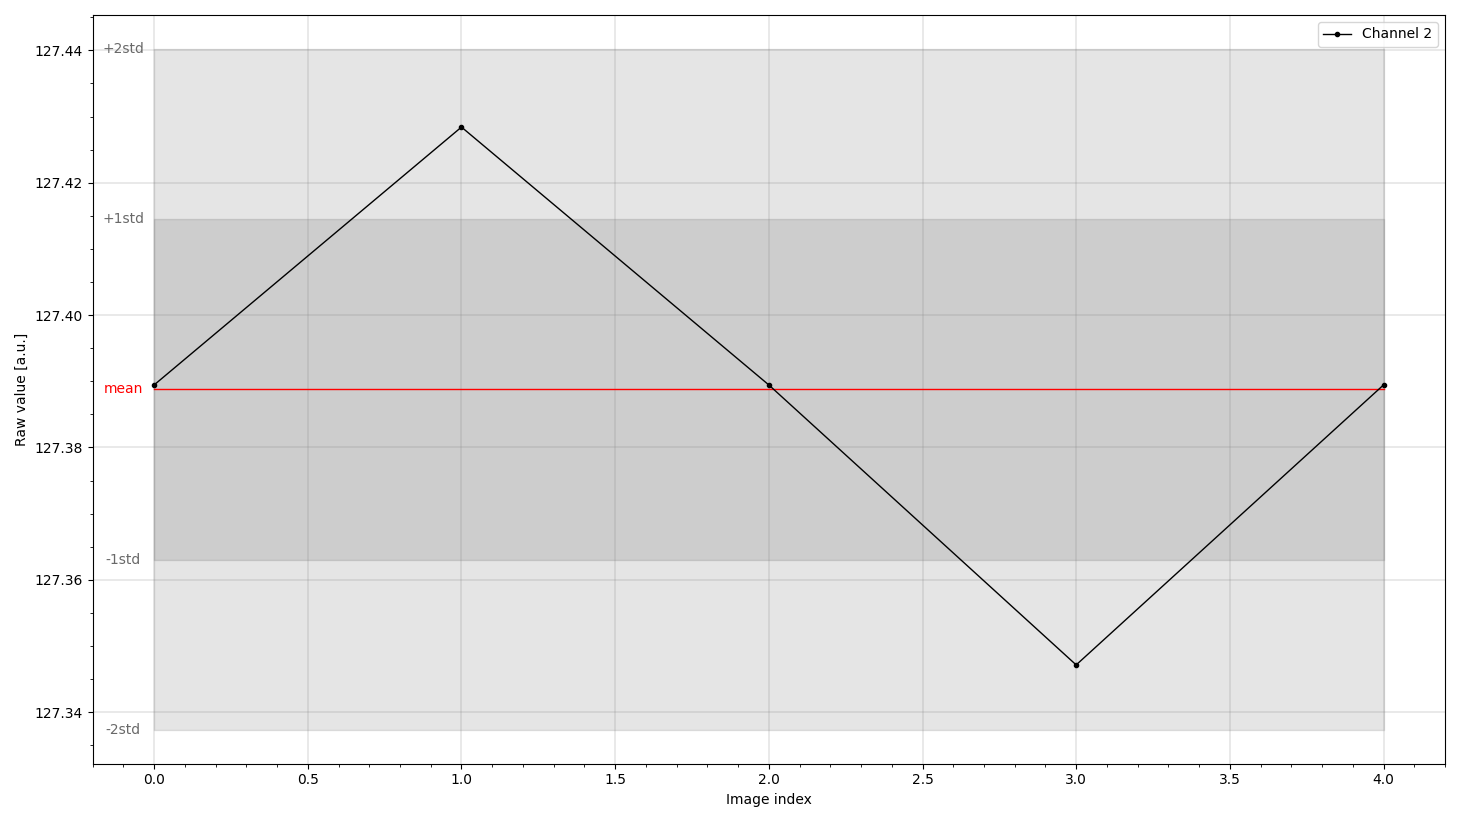

-> Completed.


In [5]:
# 5) plot image data (individual stability)

%matplotlib ipympl

chans_lims = {}
for c, chan in enumerate(chans):
    print(f"\n{chan}:")

    # create new plot
    fig = mpl.pyplot.figure()
    ax = fig.add_subplot(111)  # row, column, index

    # prepare variables for plotting
    chan_xy_vals = range(len(chans_stats[chan]["mean"])), chans_stats[chan]["mean"]
    chan_mean = np.nanmean(chans_stats[chan]["mean"])
    chan_std = np.nanstd(chans_stats[chan]["mean"])

    # add channel limits
    chans_lims[chan] = {"levje": {}}
    chans_lims_keys = [("+2std", "-2std"), ("+1std", "-1std")]
    chans_lims[chan]["levje"] = {
        chans_lims_keys[0][0]: chan_mean + 2.0 * chan_std,
        chans_lims_keys[1][0]: chan_mean + 1.0 * chan_std,
        chans_lims_keys[1][1]: chan_mean - 1.0 * chan_std,
        chans_lims_keys[0][1]: chan_mean - 2.0 * chan_std,
    }
    for upper, lower in chans_lims_keys:
        mpl.pyplot.fill_between(
            chan_xy_vals[0],
            chans_lims[chan]["levje"][upper],
            chans_lims[chan]["levje"][lower],
            color="black",
            alpha=0.1,
        )
        mpl.pyplot.annotate(
            upper,
            xy=(-0.1, chans_lims[chan]["levje"][upper]),
            ha="center",
            va="center",
            color="dimgray",
        )
        mpl.pyplot.annotate(
            lower,
            xy=(-0.1, chans_lims[chan]["levje"][lower]),
            ha="center",
            va="center",
            color="dimgray",
        )

    # add channel mean
    mpl.pyplot.plot(
        [chan_xy_vals[0][0], chan_xy_vals[0][-1]],
        [chan_mean, chan_mean],
        "red",
        label="_",
        linewidth=1,
    )
    mpl.pyplot.annotate(
        "mean", xy=(-0.1, chan_mean), ha="center", va="center", color="red"
    )

    # plot error bars
    mpl.pyplot.errorbar(
        chan_xy_vals[0],
        chan_xy_vals[1],
        fmt="o-",
        linewidth=1,
        markersize=3,
        color="black",
        label=chan,
    )

    # add legend
    mpl.pyplot.legend()

    # adjust axes
    mpl.pyplot.minorticks_on()

    # add axes labels
    mpl.pyplot.ylabel("Raw value [a.u.]")
    if chan == chans[-1]:
        mpl.pyplot.xlabel("Image index")

    # add grid
    mpl.pyplot.grid(color="gray", linewidth=0.25)

    # define image file path closest to cursor
    img_at_cursor = ax.text(
        0.5,
        0.975,
        "",
        transform=ax.transAxes,
        ha="center",
        va="center",
        fontsize=10,
        color="red",
    )

    # find image file path closest to cursor
    def show_img(
        event, chan_xy_vals=chan_xy_vals, files=files, text=img_at_cursor, fig=fig
    ):
        if event.inaxes:  # and event.xdata is not None and event.ydata is not None:
            dists_to_cursor = np.abs(chan_xy_vals[0] - event.xdata)
            closest_index = np.argmin(dists_to_cursor)
            text.set_text(f'{closest_index} => "{imgs_paths[closest_index]}"')
        else:
            text.set_text("")

    # show image file path closest to cursor
    fig.canvas.mpl_connect("motion_notify_event", show_img)

    # show plot
    mpl.pyplot.tight_layout()
    mpl.pyplot.show()

print("-> Completed.")

### Outliers I

In [6]:
# 6) list outliers for image data (individual stability)
if list_outliers:
    chans_outliers = {}
    for chan in chans:
        chans_outliers[chan] = {
            "levje": {"+2std": [], "+1std": [], "-1std": [], "-2std": []}
        }
        print(
            f"{chan} @ {', '.join([f'{value}{unit}' for value, unit in sorted(set(expos_found[chan]))])}"
        )
        for img, mean in zip(imgs, chans_stats[chan]["mean"]):
            if mean > chans_lims[chan]["levje"]["+2std"]:
                chans_outliers[chan]["levje"]["+2std"].append((img, mean))
            elif mean < chans_lims[chan]["levje"]["-2std"]:
                chans_outliers[chan]["levje"]["-2std"].append((img, mean))
            elif mean > chans_lims[chan]["levje"]["+1std"]:
                chans_outliers[chan]["levje"]["+1std"].append((img, mean))
            elif mean < chans_lims[chan]["levje"]["-1std"]:
                chans_outliers[chan]["levje"]["-1std"].append((img, mean))
        if chans_outliers[chan]["levje"]["+2std"]:
            print("\t▲▲ +2std")
            for img, mean in chans_outliers[chan]["levje"]["+2std"]:
                print(f"\t\t{mean:7.1f} -> {img}")
        if chans_outliers[chan]["levje"]["+1std"]:
            print("\t▲ +1std")
            for img, mean in chans_outliers[chan]["levje"]["+1std"]:
                print(f"\t\t{mean:7.1f} -> {img}")
        if chans_outliers[chan]["levje"]["-1std"]:
            print("\t▼ -1std")
            for img, mean in chans_outliers[chan]["levje"]["-1std"]:
                print(f"\t\t{mean:7.1f} -> {img}")
        if chans_outliers[chan]["levje"]["-2std"]:
            print("\t▼▼ -2std")
            for img, mean in chans_outliers[chan]["levje"]["-2std"]:
                print(f"\t\t{mean:7.1f} -> {img}")
    
    print("\n-> Completed.")

Channel 1 @ 0.001s
	▲ +1std
		  159.6 -> /Users/christian/Documents/GitHub/LaQuacco/tests/image_4.ome.tiff
	▼ -1std
		  101.9 -> /Users/christian/Documents/GitHub/LaQuacco/tests/image_2.ome.tiff
Channel 2 @ 0.001s
	▲ +1std
		  127.4 -> /Users/christian/Documents/GitHub/LaQuacco/tests/image_2.ome.tiff
	▼ -1std
		  127.3 -> /Users/christian/Documents/GitHub/LaQuacco/tests/image_4.ome.tiff

-> Completed.


### Sampling II

In [7]:
# 7) retrieve image data (group statistics)
files_len = len(files)
start = time.time()
update_start = ""
update_stop = ""
update_max = 0
for count, file in enumerate(files, start=1):
    update_start = f"IMAGE: {file}\t[{count}/{files_len}]"
    update_len = len(update_start) + len(update_stop)
    update_max = update_len if update_len > update_max else update_max
    print(f"\r{update_start}{update_stop}{' ':<{update_max - update_len}}", end="")

    # get group image statistics
    tmp = laq.copy_file(file) if copy_images else file  # optional file copy
    img = laq.get_img(tmp)
    imgs_chans_stats[file].update(
        laq.get_img_chans_stats(
            img, annos=annos[file], chans_limits=channel_limits, chans_means=chans_means
        )
    )

    # remove image objects
    img["tiff"].close()
    if copy_images and tmp != file:
        shutil.rmtree(os.path.dirname(tmp))

    update_stop = f" (-{laq.get_time_left(start, count, len(files))})"
print(f"\r{' ' * update_max}\r", end="")  # clear line

print("\n-> Completed.")

                                                                                     
-> Completed.


### Summary II

In [8]:
# 8) print image data (group statistics)
order = ["band_3", "lim_2", "band_2", "lim_1", "band_1", "lim_0", "band_0"]
stats = sorted(
    list(
        set(
            stat
            for chans_stats in imgs_chans_stats.values()
            for stat in chans_stats.values()
            for stat in stat.keys()
        )
    ),
    key=lambda x: order.index(x),
)
chans_stats = {
    chan: {
        stat: np.asarray(
            [
                imgs_chans_stats[img][chan][stat]
                if chan in imgs_chans_stats[img]
                else None
                for img in imgs_chans_stats.keys()
            ],
            dtype=np.float64,
        )
        for stat in stats
    }
    for chan in chans
}

# print data
for chan in chans:
    print(
        f"{chan} @ {', '.join([f'{value}{unit}' for value, unit in sorted(set(expos_found[chan]))])}"
    )
    for stat in stats:
        print(
            f"\t{stat}\t{np.nanmean(chans_stats[chan][stat]):7.1f} (mean)\t{np.nanstd(chans_stats[chan][stat]):7.1f} (std)"
        )

print("\n-> Completed.")

Channel 1 @ 0.001s
	band_3	  224.2 (mean)	    1.1 (std)
	lim_2	  191.2 (mean)	    0.0 (std)
	band_2	  159.5 (mean)	    0.1 (std)
	lim_1	  127.5 (mean)	    0.0 (std)
	band_1	   93.9 (mean)	    3.6 (std)
	lim_0	   63.8 (mean)	    0.0 (std)
	band_0	   33.5 (mean)	    3.8 (std)
Channel 2 @ 0.001s
	band_3	  223.5 (mean)	    0.0 (std)
	lim_2	  191.2 (mean)	    0.0 (std)
	band_2	  159.5 (mean)	    0.0 (std)
	lim_1	  127.5 (mean)	    0.0 (std)
	band_1	   95.5 (mean)	    0.0 (std)
	lim_0	   63.8 (mean)	    0.0 (std)
	band_0	   31.5 (mean)	    0.0 (std)

-> Completed.


### Dynamics: C-Band Charts


Channel 1:


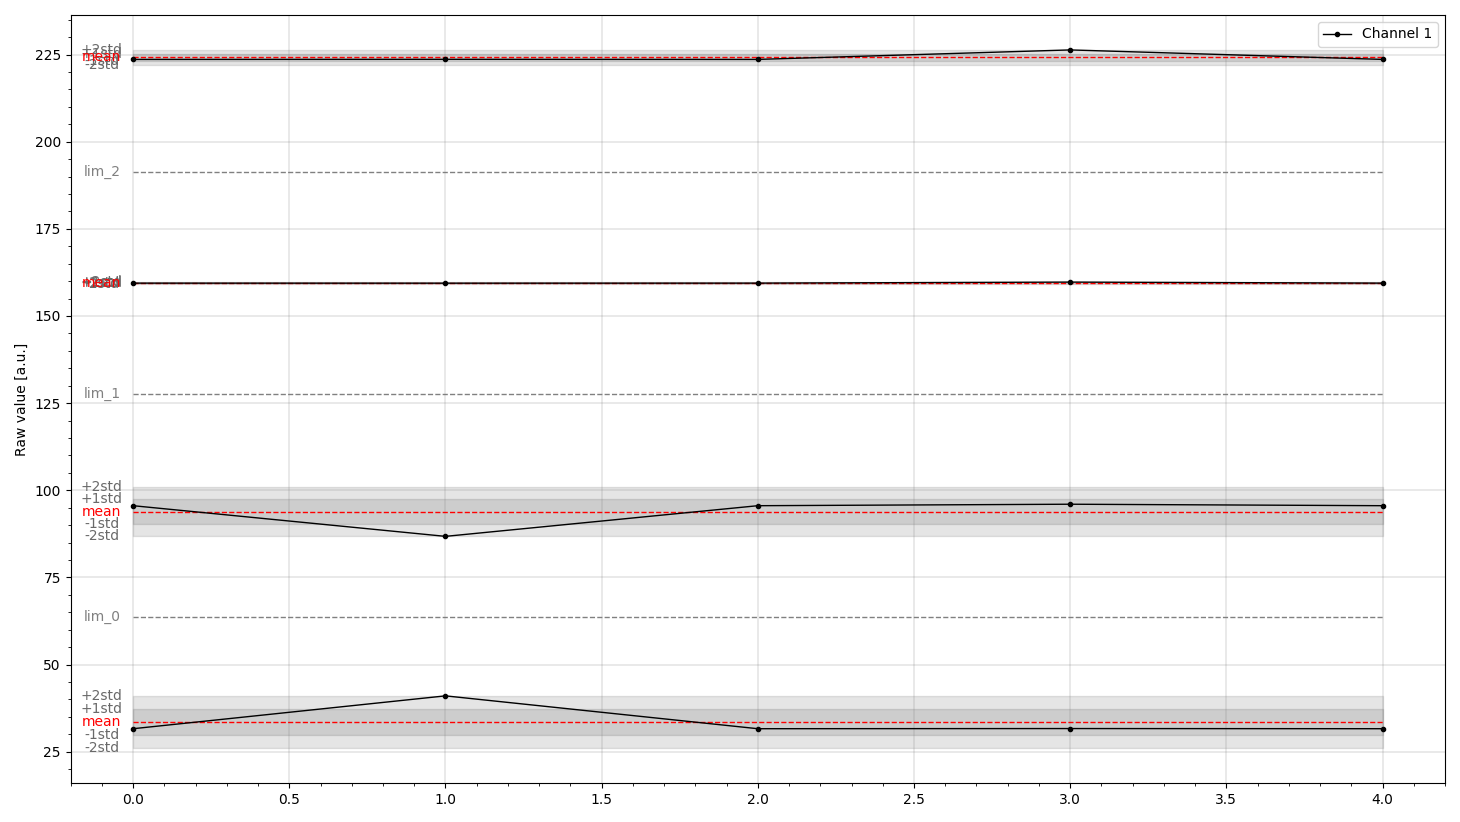


Channel 2:


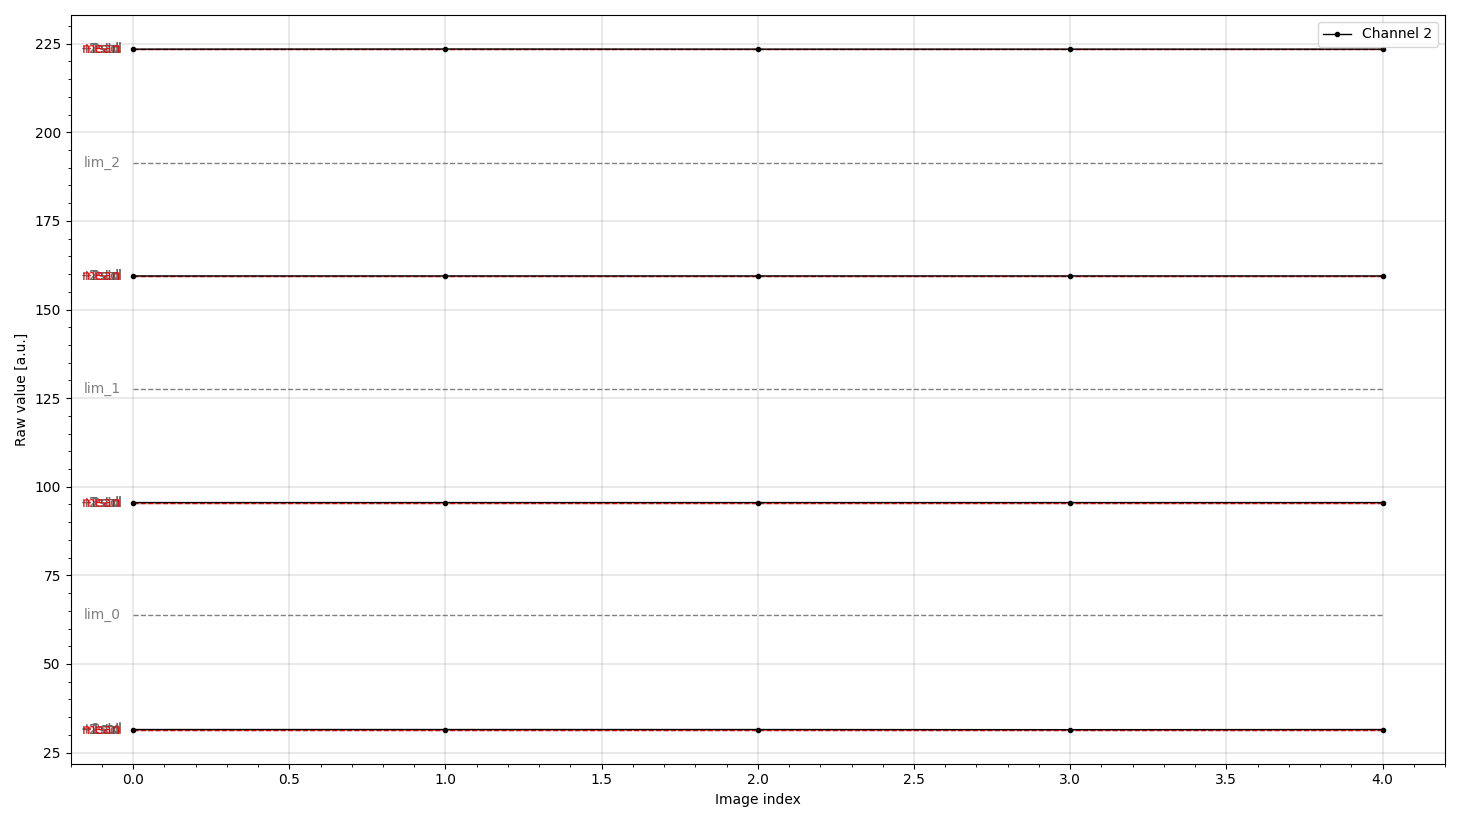

-> Completed.


In [9]:
# 9) plot image data (group statistics)

%matplotlib ipympl

bands = [stat for stat in stats if stat.startswith("band_")]
for c, chan in enumerate(chans):
    print(f"\n{chan}:")

    # create new plot
    fig = mpl.pyplot.figure()
    ax = fig.add_subplot(111)  # row, column, index

    # prepare variables for plotting
    chan_max = chans_means[chan]["max"]
    chan_mean = chans_means[chan]["mean"]
    chan_min = chans_means[chan]["min"]

    chans_lims[chan]["cbands"] = {}
    for b, band in enumerate(bands, start=1):
        # prepare variables for plotting
        band_xy_vals = range(len(chans_stats[chan][band])), chans_stats[chan][band]
        band_mean = np.nanmean(chans_stats[chan][band])
        band_std = np.nanstd(chans_stats[chan][band])

        # add channel bands limits
        band_lims_keys = [("+2std", "-2std"), ("+1std", "-1std")]
        chans_lims[chan]["cbands"][band] = {
            band_lims_keys[0][0]: band_mean + 2.0 * band_std,
            band_lims_keys[1][0]: band_mean + 1.0 * band_std,
            band_lims_keys[1][1]: band_mean - 1.0 * band_std,
            band_lims_keys[0][1]: band_mean - 2.0 * band_std,
        }
        for upper, lower in band_lims_keys:
            mpl.pyplot.fill_between(
                band_xy_vals[0],
                chans_lims[chan]["cbands"][band][upper],
                chans_lims[chan]["cbands"][band][lower],
                color="black",
                alpha=0.1,
            )
            mpl.pyplot.annotate(
                upper,
                xy=(-0.1, chans_lims[chan]["cbands"][band][upper]),
                ha="center",
                va="center",
                color="dimgray",
            )
            mpl.pyplot.annotate(
                lower,
                xy=(-0.1, chans_lims[chan]["cbands"][band][lower]),
                ha="center",
                va="center",
                color="dimgray",
            )

        # add channel band mean
        mpl.pyplot.plot(
            [band_xy_vals[0][0], band_xy_vals[0][-1]],
            [band_mean, band_mean],
            "r--",
            label="_",
            linewidth=1,
        )
        mpl.pyplot.annotate(
            "mean", xy=(-0.1, band_mean), ha="center", va="center", color="red"
        )

        # plot channel band error bars
        mpl.pyplot.errorbar(
            band_xy_vals[0],
            band_xy_vals[1],
            fmt="o-",
            linewidth=1,
            markersize=3,
            color="black",
            label=chan,
        )

    # add band limits
    for stat in stats:
        if stat.startswith("lim_"):
            band_lim = np.nanmean(chans_stats[chan][stat])
            mpl.pyplot.plot(
                [band_xy_vals[0][0], band_xy_vals[0][-1]],
                [band_lim, band_lim],
                "--",
                color="gray",
                label="_",
                linewidth=1,
            )
            mpl.pyplot.annotate(
                stat,
                xy=(-0.1, band_lim),
                ha="center",
                va="center",
                color="gray",
            )

    # add legend
    handles, labels = mpl.pyplot.gca().get_legend_handles_labels()
    mpl.pyplot.legend([handles[0]], [labels[0]])

    # adjust axes
    mpl.pyplot.minorticks_on()

    # add axes labels
    mpl.pyplot.ylabel("Raw value [a.u.]")
    if chan == chans[-1]:
        mpl.pyplot.xlabel("Image index")

    # add grid
    mpl.pyplot.grid(color="gray", linewidth=0.25)

    # define image file path closest to cursor
    img_at_cursor = ax.text(
        0.5,
        0.975,
        "",
        transform=ax.transAxes,
        ha="center",
        va="center",
        fontsize=10,
        color="red",
    )

    # find image file path closest to cursor
    def show_img(
        event, chan_xy_vals=chan_xy_vals, files=files, text=img_at_cursor, fig=fig
    ):
        if event.inaxes:  # and event.xdata is not None and event.ydata is not None:
            dists_to_cursor = np.abs(chan_xy_vals[0] - event.xdata)
            closest_index = np.argmin(dists_to_cursor)
            text.set_text(f'{closest_index} => "{imgs_paths[closest_index]}"')
        else:
            text.set_text("")

    # show image file path closest to cursor
    fig.canvas.mpl_connect("motion_notify_event", show_img)

    # show plot
    mpl.pyplot.tight_layout()
    mpl.pyplot.show()

print("-> Completed.")

### Outliers II

In [10]:
# 10) list outliers for image data (group statistics)
if list_outliers:
    for chan in chans:
        print(
            f"{chan} @ {', '.join([f'{value}{unit}' for value, unit in sorted(set(expos_found[chan]))])}"
        )
        chans_outliers[chan] = {
            "cbands": {
                "band_0": {"+2std": [], "+1std": [], "-1std": [], "-2std": []},
                "band_1": {"+2std": [], "+1std": [], "-1std": [], "-2std": []},
                "band_2": {"+2std": [], "+1std": [], "-1std": [], "-2std": []},
                "band_3": {"+2std": [], "+1std": [], "-1std": [], "-2std": []},
            }
        }
        for band in bands:
            print(f"\t{band}")
            for img, mean in zip(imgs, chans_stats[chan][band]):
                if mean > chans_lims[chan]["cbands"][band]["+2std"]:
                    chans_outliers[chan]["cbands"][band]["+2std"].append((img, mean))
                elif mean < chans_lims[chan]["cbands"][band]["-2std"]:
                    chans_outliers[chan]["cbands"][band]["-2std"].append((img, mean))
                elif mean > chans_lims[chan]["cbands"][band]["+1std"]:
                    chans_outliers[chan]["cbands"][band]["+1std"].append((img, mean))
                elif mean < chans_lims[chan]["cbands"][band]["-1std"]:
                    chans_outliers[chan]["cbands"][band]["-1std"].append((img, mean))
            if chans_outliers[chan]["cbands"][band]["+2std"]:
                print("\t\t▲▲ +2std")
                for img, mean in chans_outliers[chan]["cbands"][band]["+2std"]:
                    print(f"\t\t\t{mean:7.1f} -> {img}")
            if chans_outliers[chan]["cbands"][band]["+1std"]:
                print("\t\t▲ +1std")
                for img, mean in chans_outliers[chan]["cbands"][band]["+1std"]:
                    print(f"\t\t\t{mean:7.1f} -> {img}")
            if chans_outliers[chan]["cbands"][band]["-1std"]:
                print("\t\t▼ -1std")
                for img, mean in chans_outliers[chan]["cbands"][band]["-1std"]:
                    print(f"\t\t\t{mean:7.1f} -> {img}")
            if chans_outliers[chan]["cbands"][band]["-2std"]:
                print("\t\t▼▼ -2std")
                for img, mean in chans_outliers[chan]["cbands"][band]["-2std"]:
                    print(f"\t\t\t{mean:7.1f} -> {img}")

    print("\n-> Completed.")

Channel 1 @ 0.001s
	band_3
		▲ +1std
			  226.3 -> /Users/christian/Documents/GitHub/LaQuacco/tests/image_4.ome.tiff
	band_2
		▲ +1std
			  159.7 -> /Users/christian/Documents/GitHub/LaQuacco/tests/image_4.ome.tiff
	band_1
		▼ -1std
			   86.8 -> /Users/christian/Documents/GitHub/LaQuacco/tests/image_2.ome.tiff
	band_0
		▲ +1std
			   41.0 -> /Users/christian/Documents/GitHub/LaQuacco/tests/image_2.ome.tiff
Channel 2 @ 0.001s
	band_3
		▲ +1std
			  223.5 -> /Users/christian/Documents/GitHub/LaQuacco/tests/image_2.ome.tiff
	band_2
		▲ +1std
			  159.5 -> /Users/christian/Documents/GitHub/LaQuacco/tests/image_2.ome.tiff
			  159.5 -> /Users/christian/Documents/GitHub/LaQuacco/tests/image_4.ome.tiff
	band_1
		▲ +1std
			   95.5 -> /Users/christian/Documents/GitHub/LaQuacco/tests/image_2.ome.tiff
			   95.5 -> /Users/christian/Documents/GitHub/LaQuacco/tests/image_4.ome.tiff
	band_0
		▼ -1std
			   31.4 -> /Users/christian/Documents/GitHub/LaQuacco/tests/image_4.ome.tiff

-> Completed.
